In [1]:
from run_scReGAT import *

In [2]:
seed = 42
set_seed(seed)

In [3]:
with open('../Cortex_zy/dataset_atac.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)
    
graph = ATACGraphDataset('../Cortex_zy/input_graph/')

In [4]:
import pandas as pd
import numpy as np

test_cell = pd.read_csv('../Cortex_zy/test_barcode.txt', header=None)[0].values

In [5]:
balanced_train_graph, test_graph = preprocess_graph(dataset_atac, graph, test_cell, max_random_sample=500, seed=seed)

Processing samples: 100%|█████████▉| 499/500 [00:00<00:00, 846.85it/s]


In [6]:
len(balanced_train_graph)

3857

In [7]:
model = SCReGAT()


In [9]:
model = train_model(model, balanced_train_graph, num_epoch=1, batch_size=16, lr=0.0001, max_grad_norm=1.0, sparse_loss_weight=0.1, use_device='cuda:3')

Epoch 1/1: 100%|██████████| 242/242 [02:02<00:00,  1.98batch/s, loss=3.16, loss1=2.89, sparse_loss=0.274]

Epoch [1/1], Average Loss: 3.1598, Loss1: 2.8856, Sparse Loss: 0.2743


In [10]:
res = test_model(model, test_graph, batch_size=8, device='cuda:2')

Processing Batches: 100%|██████████| 132/132 [00:16<00:00,  7.97it/s]


In [13]:
res['cell_link_edge']

tensor([[ 0.9508,  0.7806,  0.7806,  ...,  0.3570, -0.0041, -0.0048],
        [ 0.9488,  0.8843,  0.9518,  ..., -0.0021, -0.0080, -0.0068],
        [ 0.9505, -0.0019,  0.4120,  ..., -0.0048, -0.0048, -0.0055],
        ...,
        [ 0.9648, -0.0078, -0.0078,  ..., -0.0048, -0.0048, -0.0048],
        [ 0.2083, -0.0026, -0.0026,  ..., -0.0071, -0.0080, -0.0048],
        [ 0.9544, -0.0048, -0.0047,  ..., -0.0048, -0.0082, -0.0048]])

In [16]:
edge_names = pd.read_csv('../Cortex_zy//Interaction/Oligo_scores.txt', sep='\t', index_col=0).index
edge_list = []
for t in edge_names:
    split_res = t.split("'")
    gene_tag = split_res[1]
    region = split_res[3]
    edge_list.append(gene_tag + '-' + region)

cols1 = graph[0].edge_index[0, :]
cols2 = graph[0].edge_index[1, :]
# cols1 = shuffled_edge_index1
# cols2 = shuffled_edge_index2

tag1 = [dataset_atac.array_peak[t] for t in cols2]
tag2 = [dataset_atac.array_peak[t] for t in cols1]

edge_names_anchors = [t1+'-'+t2 for t1, t2 in zip(tag1, tag2)]

edge_index = []
for t in edge_list:
    try:
        edge_index.append(edge_names_anchors.index(t))
    except:
        continue
        


In [19]:
test_barcodes = res['test_barcodes']
cell_link_edge = res['cell_link_edge']

In [18]:
cell_type_cpu = dataset_atac.adata.obs.loc[test_barcodes]['celltype'].values
cell_type_cpu = np.array(cell_type_cpu)
unique_celltype = list(dataset_atac.array_celltype)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



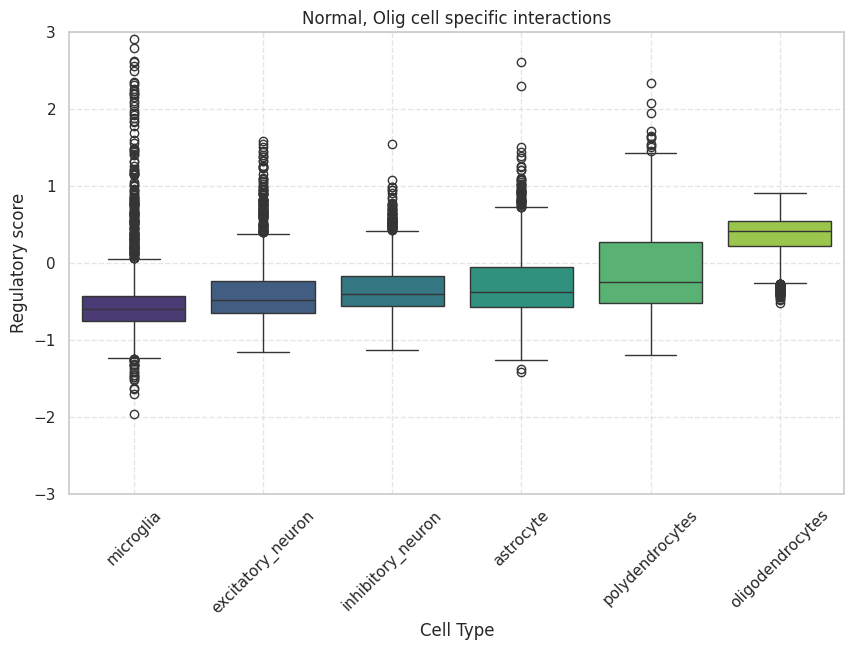

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

temp_normalized = cell_link_edge[:, edge_index].cpu().numpy()
temp_normalized = zscore(temp_normalized, axis=0) 

means = [np.mean(temp_normalized[cell_type_cpu == unique_celltype[i], :], axis=0) for i in range(len(unique_celltype))]

# 创建数据框并按均值排序
mean_data = {'Group': ['Type ' + str(i) for i in range(len(unique_celltype))],
             'Mean': [np.median(m) for m in means]}
mean_df = pd.DataFrame(mean_data).sort_values(by='Mean')

# 准备用于绘图的数据
sorted_means = [means[int(group.split(' ')[1])] for group in mean_df['Group']]
data = {'Group': np.repeat(mean_df['Group'], [len(m) for m in sorted_means]),
        'Values': np.concatenate(sorted_means)}
df = pd.DataFrame(data)
mean_df['Group'] = [unique_celltype[int(group.split(' ')[1])] for group in mean_df['Group']]

# 用更新的 Group 名字来替换 data 中的 Group
df['Group'] = [unique_celltype[int(group.split(' ')[1])] for group in df['Group']]

sns.set(style="whitegrid") 
palette = sns.color_palette("viridis", len(unique_celltype))  

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Values', data=df, order=mean_df['Group'], palette=palette)
plt.title("Normal, Olig cell specific interactions")
plt.ylabel("Regulatory score")
plt.xlabel("Cell Type")
plt.ylim(-3, 3)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# plt.savefig('./fig/B_cell.png')
plt.show()